In [1]:
                  

import numpy as np 
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin
/kaggle/input/testdata/test.xlsx


# LOADING LIBRARIES

In [2]:
import spacy
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LOADING WORD2VEC MODEL

In [3]:
word2vec_model_path = '/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)
nlp = spacy.load("en_core_web_sm")
nlp.vocab.vectors = spacy.vocab.Vectors(data=word2vec_model.vectors, keys=word2vec_model.index_to_key)

> LOADING DATASET

In [4]:
file_path = '/kaggle/input/testdata/test.xlsx'
df = pd.read_excel(file_path)
nlp=spacy.load("en_core_web_sm")
df['details'] = df['details'].apply(lambda x: ' '.join(x.split()[5:]))
df.rename(columns={'Church ID': 'Church_ID'}, inplace=True)
df.head()



,Church_ID,size,details
0,1,medium-sized church,"A Fresh Wind Church, located in Elyria, Ohio, ..."
1,2,small church,"A God Send Ministries, Inc (AGSM) is a spiritu..."
2,3,small church,We are a spirit filled congregation with much ...
3,4,medium-sized church,"Our Mailing Address: P.O. Box 806, Blythewood,..."
4,5,small church,"We are a church, ""Where serving communities is..."


# PREPROCESSING THE TEXT COLUMN DATA

In [5]:
from spacy.lang.en.stop_words import STOP_WORDS
import string
def remove_local_addresses(text):
    doc = nlp(text)

    # Identify entities labeled as "ADDRESS" or "GPE" (Geopolitical Entity)
    local_address_labels = set(['ADDRESS', 'GPE'])
    local_addresses = [ent.text for ent in doc.ents if ent.label_ in local_address_labels]

    # Remove identified local addresses from the original text
    processed_text = ' '.join(token.text if token.ent_type_ not in local_address_labels else '' for token in doc)
    processed_text = ' '.join(processed_text.split())  # Remove extra spaces

    return processed_text, local_addresses



def process_text(text):
    try:
        doc = nlp(str(text))  # Ensure the input is a string
        lemmatized_words = [token.lemma_.lower() for token in doc if not token.is_punct]
        return ' '.join(lemmatized_words)
    except Exception as e:
        print(f"Error processing text: {e}")
        return ''




import re

def pre_prc(text):
    doc = nlp(text)
    filtered_text = [token.lemma_.lower() for token in doc if token.text.lower() not in STOP_WORDS and token.text not in string.punctuation]
    processed_text = ' '.join(filtered_text)

    # Remove multiple spaces, tabs, and line breaks
    processed_text = re.sub(r'\s+', ' ', processed_text)

    # Remove ellipsis character
    processed_text = processed_text.replace('…', '')

    # Replace dash between words with space
    processed_text = processed_text.replace('-', ' ')

    return processed_text




def remove_numbers(text):
    return re.sub(r'\d+', '', text)



def remove_short_words(text, min_length=2):
    return ' '.join(word for word in text.split() if len(word) >= min_length)

def remove_stopwords(text):
    doc = nlp(text)
    filtered_tokens = [token.text for token in doc if not token.is_stop]
    return ' '.join(filtered_tokens)




def remove_words(text):
    doc = nlp(text)
    filtered_text = ' '.join(token.text for token in doc if token.text.lower() not in {'mission', 'vision','p.o','mailing','address'})
    return filtered_text


def filter_non_meaningful(text):
    doc = nlp(text)
    filtered_text = ' '.join(token.text for token in doc if not token.is_stop and token.pos_ not in {'PUNCT', 'NUM', 'SYM'} and len(token.text) > 3)
    return filtered_text





df['processed_text'] = df['details'].apply(remove_local_addresses)
df['processed_text'] = df['processed_text'].apply(process_text)

df['processed_text'] = df['processed_text'].apply(pre_prc)
df['processed_text'] = df['processed_text'].apply(remove_numbers)
df['processed_text'] = df['processed_text'].apply(remove_short_words)
df['processed_text'] = df['processed_text'].apply(remove_stopwords)
df['processed_text'] = df['processed_text'].apply(filter_non_meaningful)


df['processed_text'] = df['processed_text'].apply(remove_words)







# VECTORISING TEXT DATA USING WORD2VEC

In [6]:
def vectorize_text(text):
    tokens = nlp(text)
    vectors = [word2vec_model[token.text] for token in tokens if token.text in word2vec_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

df['prc_text_vector'] = df['processed_text'].apply(vectorize_text)
first_vector = df['prc_text_vector'][0]
print("Shape of the first vector:", first_vector.shape)
df.head()


Shape of the first vector: (300,)


,Church_ID,size,details,processed_text,prc_text_vector
0,1,medium-sized church,"A Fresh Wind Church, located in Elyria, Ohio, ...",fresh wind church locate exist lead everyday p...,"[0.016000682, 0.03261908, 0.010211813, 0.09146..."
1,2,small church,"A God Send Ministries, Inc (AGSM) is a spiritu...",send ministries agsm spiritual development tra...,"[0.054047853, 0.026462402, 0.009629517, 0.0366..."
2,3,small church,We are a spirit filled congregation with much ...,spirit fill congregation room grow church word...,"[0.081566945, 0.0124904085, -0.00020054409, 0...."
3,4,medium-sized church,"Our Mailing Address: P.O. Box 806, Blythewood,...",blythewood provide people enlightenment inform...,"[0.014964384, -0.05213659, 0.035587087, 0.0974..."
4,5,small church,"We are a church, ""Where serving communities is...",church serve community focus soul goal build s...,"[-0.01940918, 0.016303169, 0.033230253, 0.0844..."


# USING KMEANS CLUSTERING 

In [7]:

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

X = np.vstack(df['prc_text_vector'].to_numpy())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cosine_sim_matrix = cosine_similarity(X_scaled, X_scaled)

num_clusters = 2  

kmeans_cosine_scaled = KMeans(n_clusters=num_clusters, random_state=0)

df['cluster_label_cosine_scaled'] = kmeans_cosine_scaled.fit_predict(cosine_sim_matrix)




/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# WORD FREQUENCY ANALYSIS

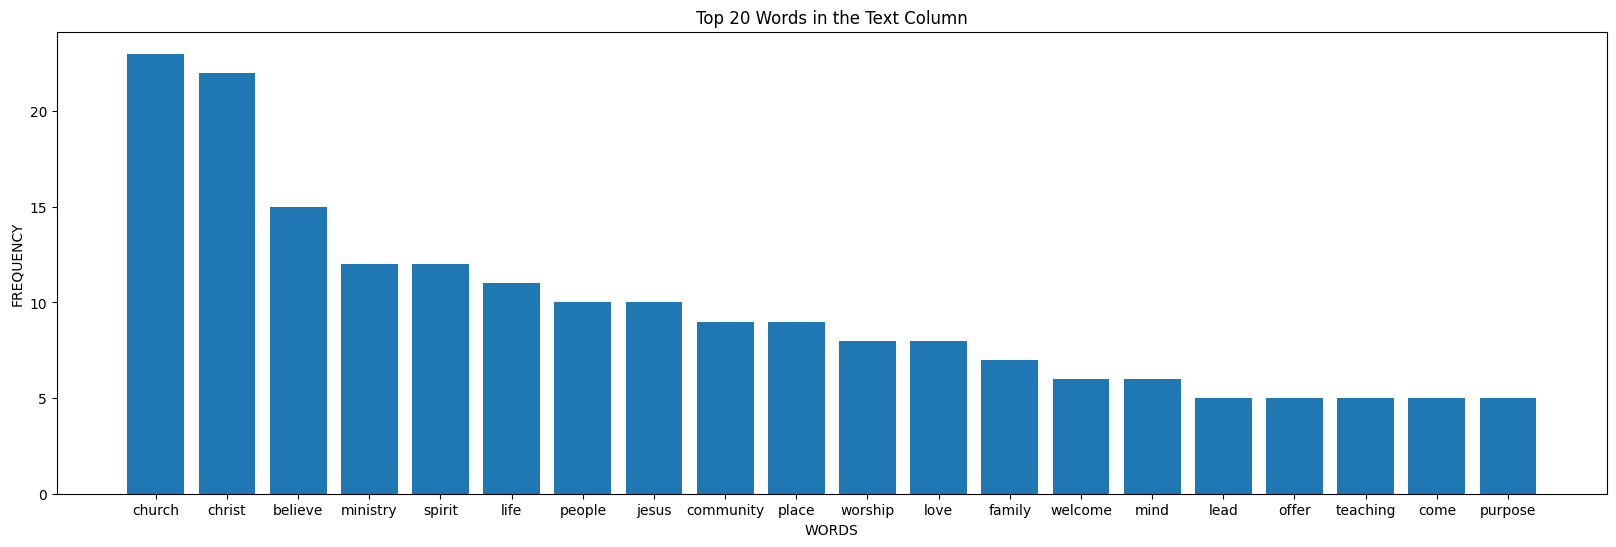

In [8]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

text_column = df['processed_text'].str.cat(sep=' ')

doc = nlp(text_column)

tokens = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]

word_freq = Counter(tokens)

top_n = 20
top_words = word_freq.most_common(top_n)

# Plot the word frequencies
plt.figure(figsize=(20, 6))
plt.bar(*zip(*top_words))
plt.xlabel('WORDS')
plt.ylabel('FREQUENCY')
plt.title(f'Top {top_n} Words in the Text Column')
plt.show()


# WORD FREQUENCY DISTRIBUTION IN DIFFERENT CLUSTERS

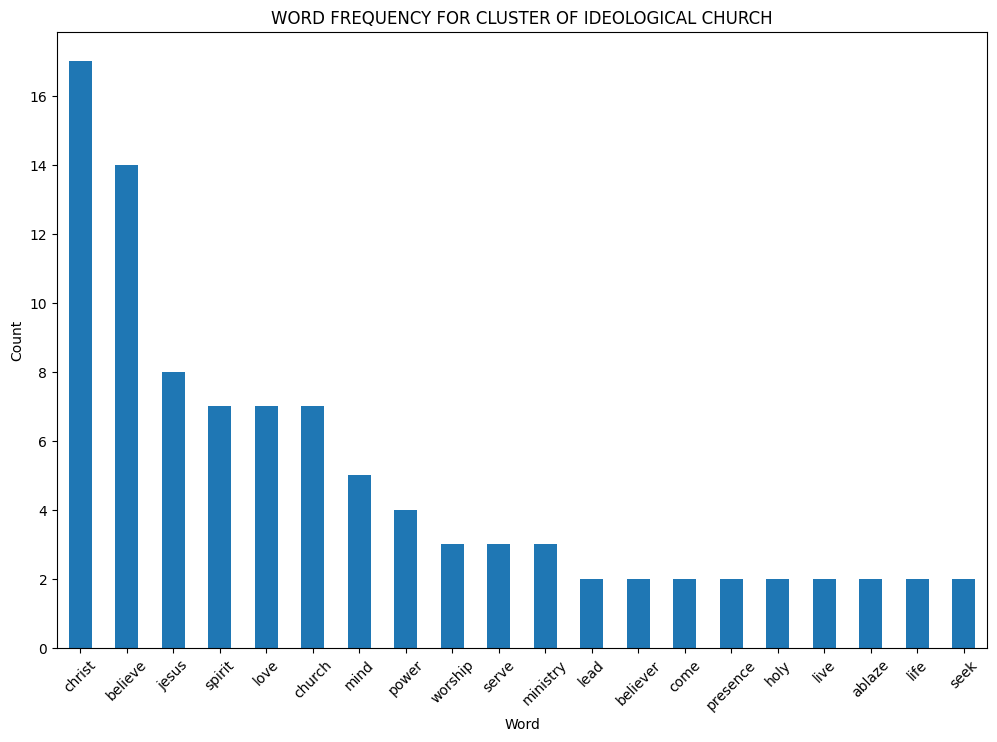

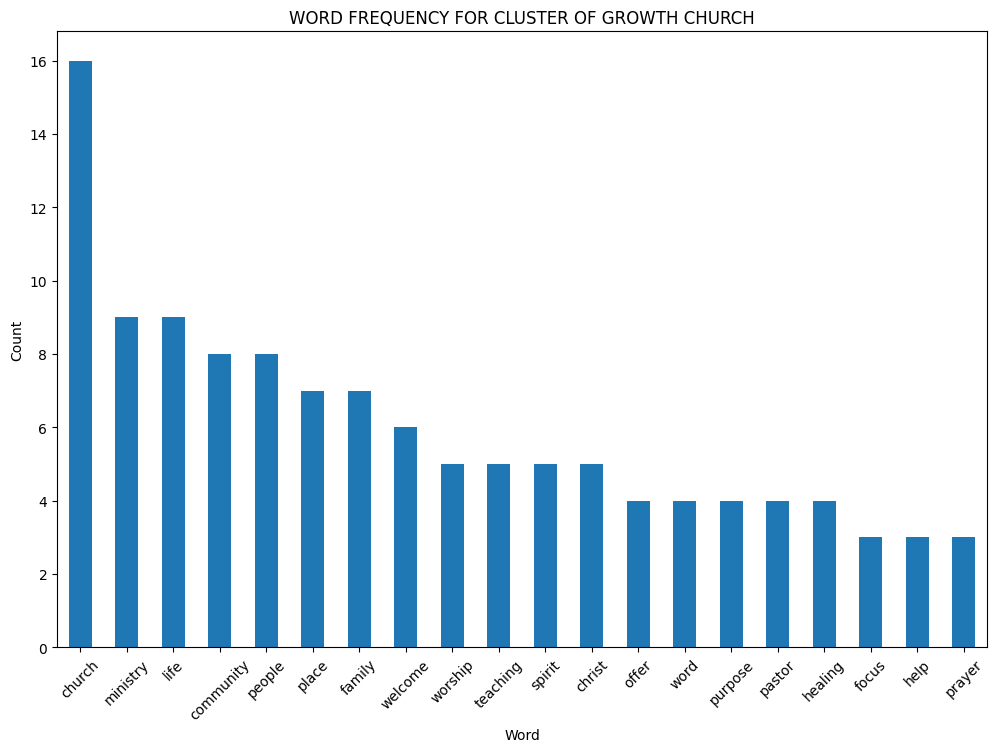

In [9]:
def plot_word_frequency(cluster_label, title_text, figsize=(12, 8)):
    cluster_df = df[df['cluster_label_cosine_scaled'] == cluster_label]

    cluster_text = ' '.join(cluster_df['processed_text'].tolist())

    words = cluster_text.split()

    word_counts = pd.Series(words).value_counts()

    top_n = 20
    fig, ax = plt.subplots(figsize=figsize)
    word_counts[:top_n].plot(kind='bar', ax=ax)
    ax.set_xlabel('Word')
    ax.set_ylabel('Count')
    ax.set_title(title_text)  
    ax.tick_params(axis='x', rotation=45)

    plt.show()

plot_word_frequency(0, title_text='WORD FREQUENCY FOR CLUSTER OF IDEOLOGICAL CHURCH', figsize=(12, 8))

plot_word_frequency(1, title_text='WORD FREQUENCY FOR CLUSTER OF GROWTH CHURCH', figsize=(12, 8))



# WORDCLOUD DISTRIBUTION IN GROWTH CHURCH AND IDEOLOGICAL CHURCH

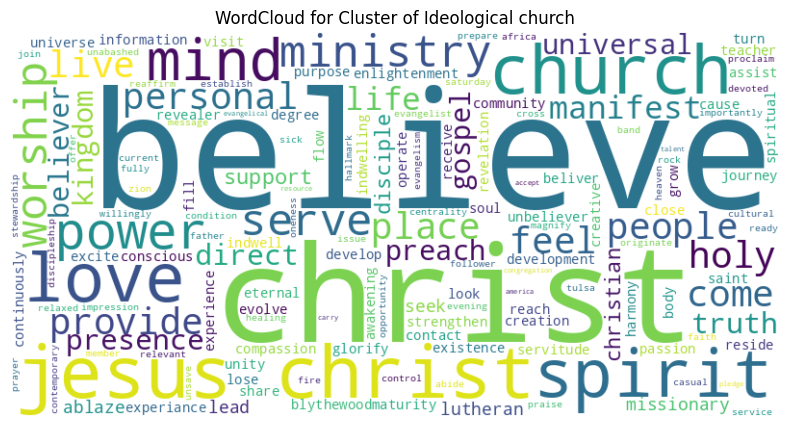

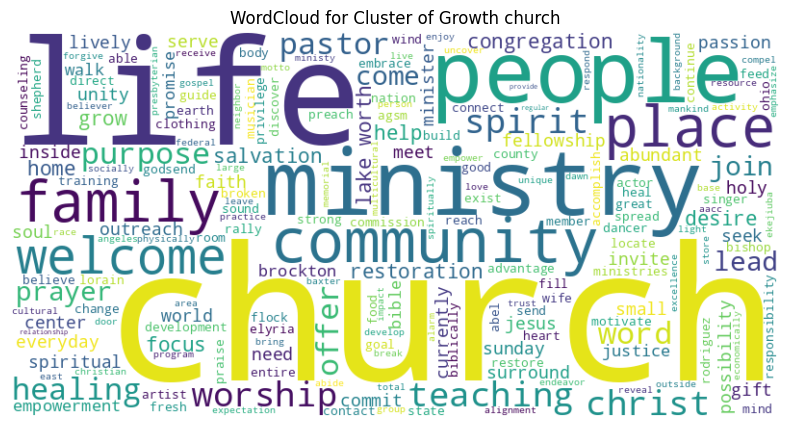

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt


cluster_0_data = df[df['cluster_label_cosine_scaled'] == 0]['processed_text']
cluster_1_data = df[df['cluster_label_cosine_scaled'] == 1]['processed_text']

wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_0_data))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('WordCloud for Cluster of Ideological church')
plt.axis('off')
plt.show()

wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cluster_1_data))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('WordCloud for Cluster of Growth church')
plt.axis('off')
plt.show()


# IDENTIFYING WORDS FOR CLASSIFICATION

In [28]:
# growth_words=["Expansion","Evangelism","church","vision","Welcome","Participation","Join","welcome","invite","rally","embrace",
#               "word","community","nations","spread","world","visit","looking","come","outreach","impact","economically",
#               "socially","physically","programs","activities","offerings","resources","place","races","nationalities","culture","background",
#               "missionary","word","provide","developing","neighbours","groups","empowerment","people","worship","mission"]

growth_words=["vision","offer","new","word","grow","join","faamily","life","church","worship","welcome","lead","love","jesus",
              "mission","people","community","serve","fellowship","worth","neighbours","empowerment","activities","programs","spread","visit"]

# ideological_words=["Devotion","spirit","Worship",
#                     "god","father","holy","spirit","congregation","preach","gospel","worship",
#                     "ministry","Healing","Eternal","Belief","Spirituality","Sacred","Enlightenment","Obedience",
#                     "jesus","christ","beleive","creation","universe","oneness","law","heaven","kingdom",
#                     "existence","message","preach",
#                     "unbeleivers","place","man"]

ideological_words=["beleive","spirit","ministry","man","holy","place","mind","power","teaching","direct","passion","worship",
                   "healing","lively","congregation","manifest","offer","god","gospel","christ"]

# STATISTICAL SCORES

*  # Cosine Similarity With Respect To Growth And Ideological Words

In [12]:
from sklearn.metrics.pairwise import cosine_similarity




growth_words=["offer","healing","word","grow","join","family","life","church","focus","welcome","help","prayer","purpose",
              "people","community","teaching","place","ministry","fellowship","pastor","visit"]

ideological_words=["beleive","spirit","jesus","love","holy","power","serve","presence","teaching","seek","passion",
                   "live","congregation","gospel","christ"]

import spacy

nlp = spacy.load("en_core_web_sm")

def lemmatize_words_spacy(word_list):
    lemmatized_words = []
    for word in word_list:
        doc = nlp(word)
        lemmatized_word = doc[0].lemma_
        lemmatized_words.append(lemmatized_word)
    return lemmatized_words

lemmatized_growth_words= lemmatize_words_spacy(growth_words)
lemmatized_ideological_words = lemmatize_words_spacy(ideological_words)





import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy

def get_word2vec_vectors(word_list):
    vectors = [word2vec_model[word] for word in word_list if word in word2vec_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

word2vec_vectors_growth = get_word2vec_vectors(lemmatized_growth_words)
word2vec_vectors_ideological = get_word2vec_vectors(lemmatized_ideological_words)

df['prcs_vector'] = df['processed_text'].apply(lambda text: get_word2vec_vectors([token.lemma_ for token in nlp(text) if not token.is_stop]))

df['cosine_sim_growth'] = df['prcs_vector'].apply(lambda vec: cosine_similarity([vec], [word2vec_vectors_growth])[0][0])
df['cosine_sim_ideological'] = df['prcs_vector'].apply(lambda vec: cosine_similarity([vec], [word2vec_vectors_ideological])[0][0])

print(df[['Church_ID', 'cosine_sim_growth', 'cosine_sim_ideological']])

    Church_ID  cosine_sim_growth  cosine_sim_ideological
0           1           0.737368                0.673890
1           2           0.817950                0.688801
2           3           0.777391                0.682284
3           4           0.692380                0.771658
4           5           0.788220                0.638625
5           6           0.869389                0.833353
6           7           0.812934                0.625801
7           8           0.707610                0.823510
8           9           0.651811                0.521061
9          10           0.836537                0.798099
10         11           0.672287                0.835729
11         12           0.741261                0.615928
12         13           0.505746                0.746801
13         14           0.736706                0.753755
14         15           0.746547                0.686117
15         16           0.445632                0.364283
16         17           0.69627

# CLUSTER ANALYSIS

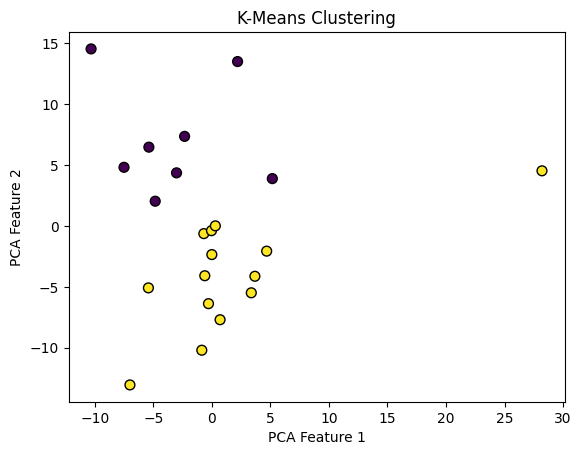

    Church_ID  cluster_label_cosine_scaled
0           1                            1
1           2                            1
2           3                            1
3           4                            0
4           5                            1
5           6                            1
6           7                            1
7           8                            0
8           9                            1
9          10                            1
10         11                            0
11         12                            1
12         13                            0
13         14                            0
14         15                            1
15         16                            1
16         17                            0
17         18                            1
18         19                            1
19         20                            0
20         21                            0
21         22                            1


In [21]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# num_clusters = 2
# kmeans_model = KMeans(n_clusters=num_clusters, random_state=0)
# clusters = kmeans.fit_predict(cosine_sim_matrix)
# df['cluster_label_cosine_scaled'] = kmeans_model.fit_predict(df['prc_text_vector'].tolist())

# scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(df['prc_text_vector'].tolist())

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(scaled_vectors)

df[['pca_feature1', 'pca_feature2']] = reduced_vectors

df['cluster_label_cosine_scaled'] = df['cluster_label_cosine_scaled'].map({0: 0, 1: 1})

plt.scatter(df['pca_feature1'], df['pca_feature2'], c=df['cluster_label_cosine_scaled'], cmap='viridis', edgecolor='k', s=50)
plt.title('K-Means Clustering')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

print(df[['Church_ID', 'cluster_label_cosine_scaled']])



* # Similarity Score With Respect To Two Reference Texts 

In [22]:
!python -m spacy download en_core_web_md


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 28.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [23]:
nlp = spacy.load("en_core_web_md")


reference_text1 = df['processed_text'][0]
reference_text2 = df['processed_text'][1]

df['similarity_score_ref1'] = df['processed_text'].apply(lambda x: nlp(x).similarity(nlp(reference_text1)))
df['similarity_score_ref2'] = df['processed_text'].apply(lambda x: nlp(x).similarity(nlp(reference_text2)))

print(df[['Church_ID', 'similarity_score_ref1', 'similarity_score_ref2']])


    Church_ID  similarity_score_ref1  similarity_score_ref2
0           1               1.000000               0.815477
1           2               0.815477               1.000000
2           3               0.831530               0.810454
3           4               0.846128               0.879852
4           5               0.814932               0.807027
5           6               0.877784               0.856310
6           7               0.826512               0.842129
7           8               0.780400               0.747533
8           9               0.656628               0.783783
9          10               0.851599               0.836700
10         11               0.839661               0.829548
11         12               0.895767               0.836256
12         13               0.712535               0.805632
13         14               0.781815               0.855045
14         15               0.756949               0.797734
15         16               0.607888    

# CLASSIFYING CHURCHES INTO GROWTH AND IDEOLOLOGICAL 

In [24]:

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

X = np.vstack(df['prc_text_vector'].to_numpy())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cosine_sim_matrix = cosine_similarity(X_scaled, X_scaled)

num_clusters = 2  

kmeans_cosine_scaled = KMeans(n_clusters=num_clusters, random_state=0)

# df['cluster_label_cosine_scaled'] = kmeans_cosine_scaled.fit_predict(cosine_sim_matrix)

# print(df['cluster_label_cosine_scaled'])
cluster_mapping = {0: 'ideological', 1: 'growth'}

# Map cluster labels to categories
df['cluster_category'] = df['cluster_label_cosine_scaled'].map(cluster_mapping)

print(df[['cluster_category']])

   cluster_category
0            growth
1            growth
2            growth
3       ideological
4            growth
5            growth
6            growth
7       ideological
8            growth
9            growth
10      ideological
11           growth
12      ideological
13      ideological
14           growth
15           growth
16      ideological
17           growth
18           growth
19      ideological
20      ideological
21           growth


# PLOTTING CHURCHES 

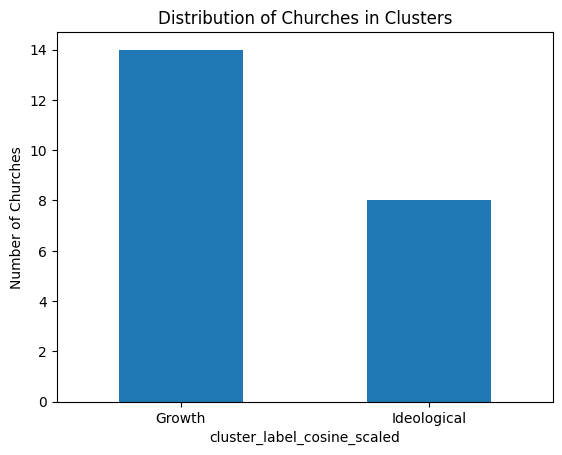

In [25]:
import matplotlib.pyplot as plt
cluster_distribution = df['cluster_label_cosine_scaled'].value_counts()
cluster_distribution.plot(kind='bar')
plt.xlabel('cluster_label_cosine_scaled')
plt.ylabel('Number of Churches')
plt.title('Distribution of Churches in Clusters')
plt.xticks(ticks=[1,0], labels=['Ideological', 'Growth'], rotation=0) 
plt.show()

# PLOT: SIZE VS TYPE

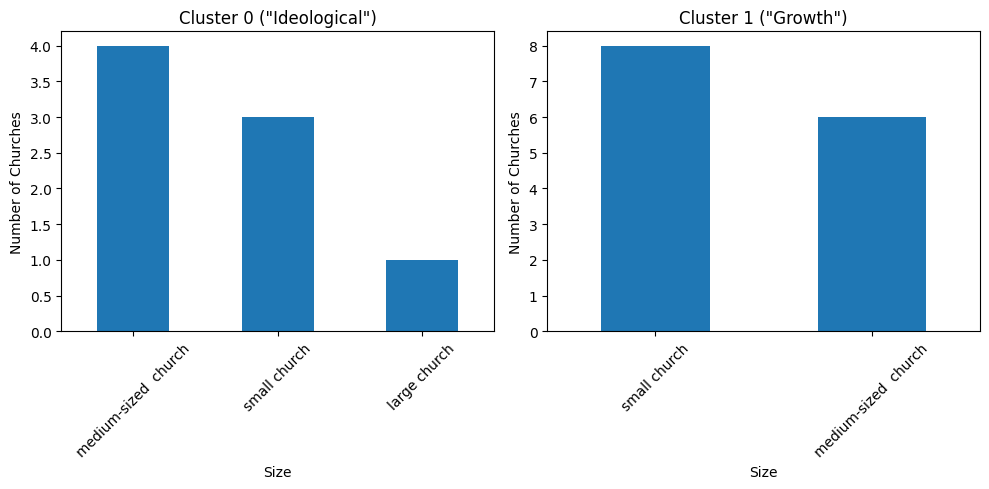

In [26]:
plt.figure(figsize=(10, 5))
for i in range(num_clusters):
    subset = df[df['cluster_label_cosine_scaled'] == i]
    plt.subplot(1, num_clusters, i+1)
    subset['size'].value_counts().plot(kind='bar')
    plt.title(f'Cluster {i} ("{"Ideological" if i == 0 else "Growth"}")')
    plt.xlabel('Size')
    plt.ylabel('Number of Churches')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

In [27]:
df.head()

,Church_ID,size,details,processed_text,prc_text_vector,cluster_label_cosine_scaled,prcs_vector,cosine_sim_growth,cosine_sim_ideological,pca_feature1,pca_feature2,similarity_score_ref1,similarity_score_ref2,cluster_category
0,1,medium-sized church,"A Fresh Wind Church, located in Elyria, Ohio, ...",fresh wind church locate exist lead everyday p...,"[0.016000682, 0.03261908, 0.010211813, 0.09146...",1,"[0.016000682, 0.03261908, 0.010211813, 0.09146...",0.737368,0.673890,-5.419604,-5.083682,1.000000,0.815477,growth
1,2,small church,"A God Send Ministries, Inc (AGSM) is a spiritu...",send ministries agsm spiritual development tra...,"[0.054047853, 0.026462402, 0.009629517, 0.0366...",1,"[0.05186035, 0.029051514, 0.010684204, 0.02320...",0.817950,0.688801,4.680764,-2.065203,0.815477,1.000000,growth
2,3,small church,We are a spirit filled congregation with much ...,spirit fill congregation room grow church word...,"[0.081566945, 0.0124904085, -0.00020054409, 0....",1,"[0.081566945, 0.0124904085, -0.00020054409, 0....",0.777391,0.682284,-0.604808,-4.085795,0.831530,0.810454,growth
3,4,medium-sized church,"Our Mailing Address: P.O. Box 806, Blythewood,...",blythewood provide people enlightenment inform...,"[0.014964384, -0.05213659, 0.035587087, 0.0974...",0,"[0.014964384, -0.05213659, 0.035587087, 0.0974...",0.692380,0.771658,-2.328879,7.361762,0.846128,0.879852,ideological
4,5,small church,"We are a church, ""Where serving communities is...",church serve community focus soul goal build s...,"[-0.01940918, 0.016303169, 0.033230253, 0.0844...",1,"[-0.01940918, 0.016303169, 0.033230253, 0.0844...",0.788220,0.638625,3.367267,-5.487533,0.814932,0.807027,growth
